# Battery Thermal Trade Study (Simple Physics-Based Model)

This notebook demonstrates a simplified, explainable battery thermal model suitable for concept trade studies.

## What it includes
- Heat generation estimate (Joule heating):  Q = I²R
- Current estimated from electrical power:  I = P / V
- Lumped thermal model (single temperature state):
  dT/dt = (Q - UA*(T - Tamb)) / Cth

## Intended use
Concept-level understanding of trends and sensitivities (not a proprietary or high-fidelity OEM model).
All parameters are illustrative and can be tuned.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Assumptions & Parameters (illustrative)

Electrical:
- Pack voltage (V): constant
- Internal resistance (R): constant equivalent resistance

Thermal:
- Lumped thermal capacitance (Cth): approximated from mass * Cp
- Heat rejection: UA*(T - Tamb)
- No spatial gradients, no coolant dynamics

These are deliberately simplified to keep the model transparent.


In [2]:
# --- Electrical parameters ---
V_pack = 400.0          # V (typical EV nominal pack voltage)
R_int  = 0.050          # ohm (illustrative equivalent pack resistance)

# --- Thermal parameters ---
m_batt = 450.0          # kg (illustrative pack mass)
cp_batt = 1000.0        # J/kg-K (order-of-magnitude)
Cth = m_batt * cp_batt  # J/K

UA = 80.0               # W/K (illustrative overall heat transfer to ambient/coolant loop)

# --- Environment & initial condition ---
T_amb = 25.0            # degC
T0 = 30.0               # degC (starting pack temperature)

# --- Simulation setup ---
dt = 1.0                # seconds


In [3]:
def heat_generation_w(P_kw, V=V_pack, R=R_int):
    # Joule heating: I = P/V, Q = I^2 * R
    P_w = P_kw * 1000.0
    I = P_w / V
    Q = (I**2) * R
    return Q


def simulate_temperature(P_profile_kw, t_seconds, T_init=T0, Tamb=T_amb, UA=UA, Cth=Cth, dt=dt):
    # Lumped thermal model:
    # dT/dt = (Q - UA*(T-Tamb))/Cth
    n = len(t_seconds)
    T = np.zeros(n)
    Q = np.zeros(n)
    T[0] = T_init

    for i in range(1, n):
        Q[i] = heat_generation_w(P_profile_kw[i])
        dTdt = (Q[i] - UA*(T[i-1] - Tamb)) / Cth
        T[i] = T[i-1] + dTdt * dt

    return T, Q



In [4]:
# Trade study: constant power levels for a fixed duration
duration_min = 30
t = np.arange(0, duration_min*60 + dt, dt)

power_levels_kw = [10, 20, 30, 40, 60, 80, 100]  # kW constant draw scenarios

results = []
all_T = {}
all_Q = {}

for P in power_levels_kw:
    P_profile = np.full_like(t, P, dtype=float)
    T, Q = simulate_temperature(P_profile, t)
    all_T[P] = T
    all_Q[P] = Q

    results.append({
        "P_kw": P,
        "Q_w_initial": heat_generation_w(P),
        "T_end_C": float(T[-1]),
        "deltaT_C": float(T[-1] - T[0]),
        "Q_w_avg": float(np.mean(Q))
    })

df = pd.DataFrame(results)
df


,P_kw,Q_w_initial,T_end_C,deltaT_C,Q_w_avg
0,10,31.25,28.737623,-1.262377,31.232649
1,20,125.00,29.058566,-0.941434,124.930594
2,30,281.25,29.593472,-0.406528,281.093837
3,40,500.00,30.342340,0.342340,499.722376
4,60,1125.00,32.481962,2.481962,1124.375347
5,80,2000.00,35.477432,5.477432,1998.889506
6,100,3125.00,39.328752,9.328752,3123.264853


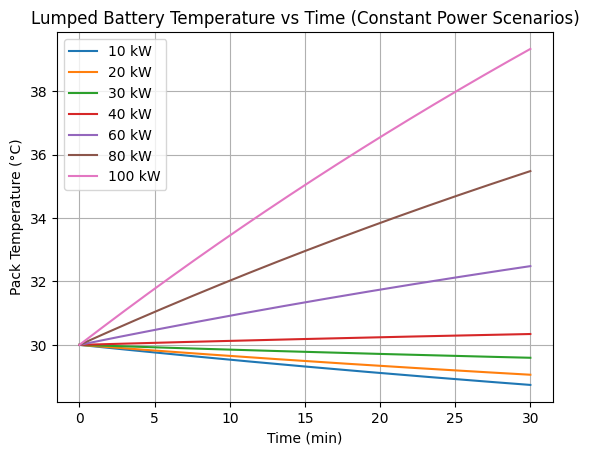

In [5]:
plt.figure()
for P in power_levels_kw:
    plt.plot(t/60, all_T[P], label=f"{P} kW")
plt.xlabel("Time (min)")
plt.ylabel("Pack Temperature (°C)")
plt.title("Lumped Battery Temperature vs Time (Constant Power Scenarios)")
plt.grid(True)
plt.legend()
plt.show()


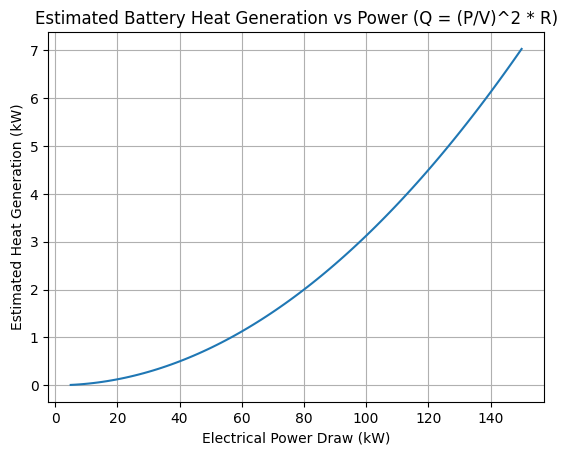

In [6]:
P_sweep = np.linspace(5, 150, 100)
Q_sweep = [heat_generation_w(P) for P in P_sweep]

plt.figure()
plt.plot(P_sweep, np.array(Q_sweep)/1000)
plt.xlabel("Electrical Power Draw (kW)")
plt.ylabel("Estimated Heat Generation (kW)")
plt.title("Estimated Battery Heat Generation vs Power (Q = (P/V)^2 * R)")
plt.grid(True)
plt.show()


In [7]:
R_values = [0.02, 0.05, 0.10]   # ohm
UA_values = [40, 80, 140]       # W/K

P_test = 80  # kW
duration_min = 30
t = np.arange(0, duration_min*60 + dt, dt)
P_profile = np.full_like(t, P_test, dtype=float)

sens_rows = []
for R in R_values:
    for UA_ in UA_values:
        T = np.zeros(len(t))
        T[0] = T0
        for i in range(1, len(t)):
            P_w = P_profile[i] * 1000.0
            I = P_w / V_pack
            Qw = (I**2) * R
            dTdt = (Qw - UA_*(T[i-1] - T_amb)) / Cth
            T[i] = T[i-1] + dTdt * dt

        sens_rows.append({
            "P_kw": P_test,
            "R_ohm": R,
            "UA_W_per_K": UA_,
            "T_end_C": float(T[-1]),
            "deltaT_C": float(T[-1]-T[0])
        })

sens_df = pd.DataFrame(sens_rows).sort_values(["R_ohm","UA_W_per_K"])
sens_df


,P_kw,R_ohm,UA_W_per_K,T_end_C,deltaT_C
0,80,0.02,40,32.217934,2.217934
1,80,0.02,80,31.369358,1.369358
2,80,0.02,140,30.306315,0.306315
3,80,0.05,40,36.653802,6.653802
4,80,0.05,80,35.477432,5.477432
5,80,0.05,140,33.982092,3.982092
6,80,0.10,40,44.046916,14.046916
7,80,0.10,80,42.324223,12.324223
8,80,0.10,140,40.108388,10.108388


## Interpretation (Engineering Notes)

- Heat generation rises roughly with **P²** in this simplified model (because I = P/V and Q = I²R).
- Higher internal resistance (R) increases thermal load significantly for the same power demand.
- Higher UA reduces temperature rise by increasing heat rejection.
- This model is intentionally simple and transparent; it’s useful for **trend studies** and **parameter sensitivity**.

## Next steps (higher fidelity, still portfolio-safe)
- Add temperature-dependent resistance (R(T))
- Add two-node model (core + surface)
- Include cooling system limits / COP vs ambient
- Add a drive-cycle power trace instead of constant power
